In [1]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.process.GHMM import markov_approximation
from epsilon_transformers.analysis.load_data import S3ModelLoader
from epsilon_transformers.analysis.activation_analysis import (
    get_msp,
    prepare_msp_data,
    run_activation_to_beliefs_regression,
    get_sweep_type,
    plot_belief_predictions,
    model_type
)

import torch
import matplotlib.pyplot as plt


## Model Loading and Exploration

In [2]:
# Initialize loader
loader = S3ModelLoader()

# List all sweeps
sweeps = loader.list_sweeps()
print("Available sweeps:")
for sweep in sweeps:
    print(f"- {sweep}")
    
    # List runs for each sweep
    runs = loader.list_runs_in_sweep(sweep)
    print(f"\nRuns in sweep {sweep}:")
    for run in runs:
        print(f"  - {run}")

        checkpoints = loader.list_checkpoints(sweep, run)
        print(f"    {len(checkpoints)} checkpoints")
        print(f"    Checkpoints:")
        for checkpoint in checkpoints[:3]:
            print(f"      - {checkpoint}")
        print(f"      - ...")

Available sweeps:
- 20241009234307

Runs in sweep 20241009234307:
  - run_0_L6_H4_DH8_DM32_post_quantum
    11 checkpoints
    Checkpoints:
      - 20241009234307/run_0_L6_H4_DH8_DM32_post_quantum/0.pt
      - 20241009234307/run_0_L6_H4_DH8_DM32_post_quantum/10240000.pt
      - 20241009234307/run_0_L6_H4_DH8_DM32_post_quantum/20480000.pt
      - ...
  - run_10_L12_H8_DH8_DM64_tom_quantum
    11 checkpoints
    Checkpoints:
      - 20241009234307/run_10_L12_H8_DH8_DM64_tom_quantum/0.pt
      - 20241009234307/run_10_L12_H8_DH8_DM64_tom_quantum/10240000.pt
      - 20241009234307/run_10_L12_H8_DH8_DM64_tom_quantum/20480000.pt
      - ...
  - run_11_L12_H8_DH8_DM64_fanizza
    11 checkpoints
    Checkpoints:
      - 20241009234307/run_11_L12_H8_DH8_DM64_fanizza/0.pt
      - 20241009234307/run_11_L12_H8_DH8_DM64_fanizza/10240000.pt
      - 20241009234307/run_11_L12_H8_DH8_DM64_fanizza/20480000.pt
      - ...
  - run_12_L6_H4_DH16_DM64_post_quantum
    11 checkpoints
    Checkpoints:
      - 

sweeps

20241121152808 - rnns (https://wandb.ai/adamimos/quantum_rnn_experiments_20241121152808)
20241205175736 - transformers (https://wandb.ai/adamimos/quantum_transformer_20241205175736)


In [7]:
# Initialize loader
from tabnanny import check


loader = S3ModelLoader()

# Get lists of available models
sweeps = loader.list_sweeps()
sweep_id = sweeps[4]  # Get first sweep
sweep_config = loader.load_sweep_config(sweep_id)
runs = loader.list_runs_in_sweep(sweep_id)
run_id = runs[0]  # Get first run
checkpoints = loader.list_checkpoints(sweep_id, run_id)
checkpoint_key = checkpoints[-1]  # Get last checkpoint
print(f"Checkpoint key: {checkpoint_key}")
config_files = loader.list_config_files(sweep_id, run_id)
print(f"Config files: {config_files}")
configs = loader.load_run_configs(sweep_id, run_id)
print(f"Configs: {configs}")
loss = loader.load_loss_from_run(sweep_id, run_id)

# Load the model

model, config = loader.load_checkpoint(
    sweep_id=sweep_id,
    run_id=run_id,
    checkpoint_key=checkpoint_key,
    device='cpu'
)


print(f"Loaded model from {checkpoint_key}")
print(f"Model config: {config['model_config']}")
print(f"Model is on device: {next(model.parameters()).device}")
print(f"Model type: {model_type(model)}")
print(f"Loss: {loss}")

Checkpoint key: 20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/4075724800.pt
Config files: ['20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/log.csv', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/log.json', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/loss.csv', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/model_config.json', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/run_config.yaml', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/stderr.txt', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/stdout.txt']
Configs: {'run_config': {'config_path': './results/20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/run_config.yaml', 'experiment_dir': './results/20241121152808/run_0_L1_H64_LSTM_uni_post_quantum', 'global_config': {'device': 'cuda:0', 'output_dir': './results', 'parallel': True, 'process_dir': './process_data', 'save_every': 100, 'scheduler': True, 'sweep_id': '20241121152808', 'val_every': 1, 'wandb': True, 'wandb_project': 'quantum_rnn_experim

In [8]:
sweeps

['20241009234307',
 '20241010142931',
 '20241010223942',
 '20241120181753',
 '20241121152808',
 '20241122095449',
 '20241205175736']

In [177]:
import pandas as pd
def create_metadata_tables(loader):
    sweeps_metadata = pd.DataFrame()
    runs_metadata = pd.DataFrame()
    
    # Get all sweeps
    sweeps = loader.list_sweeps()
    
    for sweep_id in sweeps:
        print(f"Processing sweep {sweep_id}")
        num_runs = len(loader.list_runs_in_sweep(sweep_id))
        print(f"  {num_runs} runs")
        # Try to get sweep config, continue if not found
        try:
            sweep_config = loader.load_sweep_config(sweep_id)
            # Create sweep metadata if config exists
            flattened_sweep = {
                'sweep_id': sweep_id,
                **{f'global_{k}': v for k, v in sweep_config['global_config'].items()},
                **{f'model_{k}': v for k, v in sweep_config['model_config'].items()},
                **{f'train_{k}': v for k, v in sweep_config['train_config'].items()}
            }
            
            # Handle sweep config parameters
            for section, params in sweep_config['sweep_config'].items():
                if isinstance(params, dict):
                    for k, v in params.items():
                        flattened_sweep[f'sweep_{section}_{k}'] = v
                else:
                    flattened_sweep[f'sweep_{section}'] = params
            
            sweeps_metadata = pd.concat([sweeps_metadata, 
                                       pd.DataFrame([flattened_sweep])], 
                                      ignore_index=True)
        except FileNotFoundError:
            print(f"No sweep config found for sweep {sweep_id}")
        
        # Process runs for this sweep regardless of sweep config
        runs = loader.list_runs_in_sweep(sweep_id)
        for run_id in runs:
            try:
                configs = loader.load_run_configs(sweep_id, run_id)
                run_config = configs['run_config']
                
                # Flatten run config
                flattened_run = {
                    'sweep_id': sweep_id,
                    'run_id': run_id
                }
                
                # Add all config sections
                for section, config in run_config.items():
                    if isinstance(config, dict):
                        for k, v in config.items():
                            flattened_run[f'{section}_{k}'] = v
                    else:
                        flattened_run[section] = config
                
                runs_metadata = pd.concat([runs_metadata, 
                                        pd.DataFrame([flattened_run])], 
                                        ignore_index=True)
            except Exception as e:
                print(f"Error processing run {run_id} in sweep {sweep_id}: {str(e)}")
    
    return sweeps_metadata, runs_metadata


sweeps_metadata, runs_metadata = create_metadata_tables(loader)

Processing sweep 20241009234307
  36 runs
Processing sweep 20241010142931
  36 runs
No sweep config found for sweep 20241010142931
Error loading log.csv: No columns to parse from file
Error loading loss.csv: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
Error loading log.csv: No columns to parse from file
Error loading loss.csv: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
Error loading log.csv: No columns to parse from file
Error loading loss.csv: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
Error loading log.csv: No columns to parse from file
Error loading loss.csv: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
Error loading log.csv: No columns to parse from file
Error loading loss.csv: An error occurred (NoSuchKey) when calling the GetObject operation: The spec

In [178]:
sweeps_metadata

,sweep_id,global_device,global_output_dir,global_parallel,global_process_dir,global_val_every,global_wandb,global_wandb_project,model_act_fn,model_attn_only,...,model_dropout,model_hidden_size,model_num_layers,model_rnn_type,train_batch_size,train_learning_rate,sweep_model_config_hidden_size,sweep_model_config_num_layers,sweep_model_config_rnn_type,global_sweep_id
0,20241009234307,cuda,./results,True,./process_data,1,True,quantum,relu,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20241010223942,cuda,./results,True,./process_data,1,True,quantum,relu,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20241120181753,cuda,./results,True,./process_data,1,True,quantum_rnn_experiments,NaN,NaN,...,0.0,128.0,2.0,LSTM,128.0,0.0001,"[64, 128]","[1, 2, 4]","[LSTM, GRU, RNN]",NaN
3,20241121152808,cuda,./results,True,./process_data,1,True,quantum_rnn_experiments,NaN,NaN,...,0.0,NaN,NaN,NaN,128.0,0.0001,[64],"[1, 2, 4]","[LSTM, GRU, RNN]",NaN
4,20241122095449,cuda:0,./results,True,./process_data,1,True,quantum_rnn_experiments,NaN,NaN,...,0.0,NaN,NaN,NaN,128.0,0.0001,[64],"[1, 2, 4]","[LSTM, GRU, RNN]",20241121152808


In [179]:
runs_metadata

,sweep_id,run_id,config_path,experiment_dir,global_config_device,global_config_output_dir,global_config_parallel,global_config_process_dir,global_config_sweep_id,global_config_val_every,...,global_config_scheduler,model_config_bidirectional,model_config_dropout,model_config_hidden_size,model_config_num_layers,model_config_rnn_type,process_config_pR1,process_config_pR2,process_config_a,process_config_x
0,20241009234307,run_0_L6_H4_DH8_DM32_post_quantum,./results/20241009234307/run_0_L6_H4_DH8_DM32_...,./results/20241009234307/run_0_L6_H4_DH8_DM32_...,cuda:0,./results,True,./process_data,20241009234307,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20241009234307,run_10_L12_H8_DH8_DM64_tom_quantum,./results/20241009234307/run_10_L12_H8_DH8_DM6...,./results/20241009234307/run_10_L12_H8_DH8_DM6...,cuda:1,./results,True,./process_data,20241009234307,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20241009234307,run_11_L12_H8_DH8_DM64_fanizza,./results/20241009234307/run_11_L12_H8_DH8_DM6...,./results/20241009234307/run_11_L12_H8_DH8_DM6...,cuda:5,./results,True,./process_data,20241009234307,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20241009234307,run_12_L6_H4_DH16_DM64_post_quantum,./results/20241009234307/run_12_L6_H4_DH16_DM6...,./results/20241009234307/run_12_L6_H4_DH16_DM6...,cuda:3,./results,True,./process_data,20241009234307,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20241009234307,run_13_L6_H4_DH16_DM64_tom_quantum,./results/20241009234307/run_13_L6_H4_DH16_DM6...,./results/20241009234307/run_13_L6_H4_DH16_DM6...,cuda:2,./results,True,./process_data,20241009234307,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,20241121152808,run_70_L4_H64_RNN_uni_rrxor,./results/20241121152808/run_70_L4_H64_RNN_uni...,./results/20241121152808/run_70_L4_H64_RNN_uni...,cuda:4,./results,True,./process_data,20241121152808,1,...,True,False,0.0,64.0,4.0,RNN,0.5,0.5,NaN,NaN
221,20241121152808,run_71_L4_H64_RNN_uni_mess3,./results/20241121152808/run_71_L4_H64_RNN_uni...,./results/20241121152808/run_71_L4_H64_RNN_uni...,cuda:0,./results,True,./process_data,20241121152808,1,...,True,False,0.0,64.0,4.0,RNN,NaN,NaN,0.85,0.05
222,20241121152808,run_7_L1_H64_LSTM_uni_mess3,./results/20241121152808/run_7_L1_H64_LSTM_uni...,./results/20241121152808/run_7_L1_H64_LSTM_uni...,cuda:0,./results,True,./process_data,20241121152808,1,...,True,False,0.0,64.0,1.0,LSTM,NaN,NaN,0.85,0.05
223,20241121152808,run_8_L1_H64_GRU_uni_post_quantum,./results/20241121152808/run_8_L1_H64_GRU_uni_...,./results/20241121152808/run_8_L1_H64_GRU_uni_...,cuda:5,./results,True,./process_data,20241121152808,1,...,True,False,0.0,64.0,1.0,GRU,NaN,NaN,NaN,NaN


In [10]:
loader = S3ModelLoader()

# Get lists of available models
sweeps = loader.list_sweeps()
sweep_id = sweeps[4]  # Get first sweep
print(f"Sweep ID: {sweep_id}")
runs = loader.list_runs_in_sweep(sweep_id)
run_i = 0
run_id = runs[run_i]  # Get first run
print(f"Run ID: {run_id}")

checkpoints = loader.list_checkpoints(sweep_id, run_id)
checkpoint_key = checkpoints[-1]  # Get last checkpoint
config_files = loader.list_config_files(sweep_id, run_id)
print(f"Config files: {config_files}")
configs = loader.load_run_configs(sweep_id, run_id)
#print(f"Configs: {configs}")


# Load the model
model, config = loader.load_rnn_checkpoint(
    sweep_id=sweep_id,
    run_id=run_id,
    checkpoint_key=checkpoint_key,
    device='cpu'
)

(
    nn_inputs,
    nn_beliefs,
    nn_belief_indices,
    nn_probs,
    nn_unnormalized_beliefs
) = prepare_msp_data(
    config,
    config['model_config']
)
sweep_type = get_sweep_type(run_id)

Sweep ID: 20241121152808
Run ID: run_0_L1_H64_LSTM_uni_post_quantum
Config files: ['20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/log.csv', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/log.json', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/loss.csv', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/model_config.json', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/run_config.yaml', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/stderr.txt', '20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/stdout.txt']
Config structure:
{'config_path': './results/20241121152808/run_0_L1_H64_LSTM_uni_post_quantum/run_config.yaml', 'experiment_dir': './results/20241121152808/run_0_L1_H64_LSTM_uni_post_quantum', 'global_config': {'device': 'cuda:0', 'output_dir': './results', 'parallel': True, 'process_dir': './process_data', 'save_every': 100, 'scheduler': True, 'sweep_id': '20241121152808', 'val_every': 1, 'wandb': True, 'wandb_project': 'quantum_rnn_experiments'}, 'model_con

In [11]:
a,b = model.forward_with_all_states(nn_inputs)
b = b['layer_states']


In [12]:
hidden_states = b[-1,:,:,:]
print(hidden_states.shape)
# current shape is [ctx, batch, d_model] and we want [batch, ctx, d_model]
#hidden_states = hidden_states.permute(1, 0, 2)
print(hidden_states.shape)
# Run regression for each layer
regression, belief_predictions, mse, mse_shuffled, belief_predictions_shuffled, mse_cv, belief_predictions_cv, test_inds = run_activation_to_beliefs_regression(
    hidden_states,  # Your activations
    nn_beliefs,  # Your ground truth beliefs
    nn_probs
)

torch.Size([5232, 8, 64])
torch.Size([5232, 8, 64])
5232 8 64


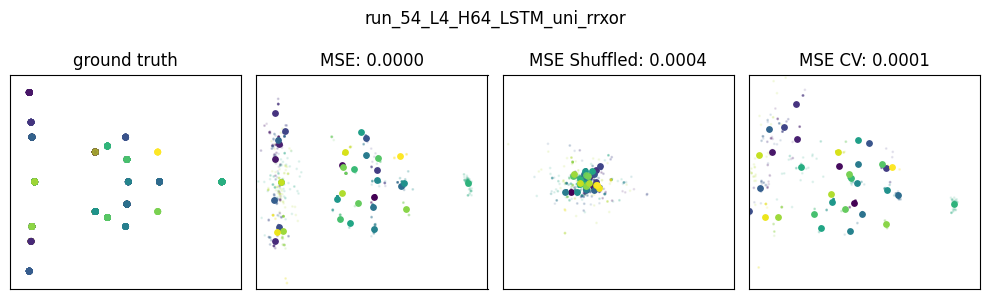

In [159]:

# Now plot with flattened arrays
fig, ax = plt.subplots(1, 4, figsize=(10, 3))

plot_belief_predictions(
    belief_predictions=nn_beliefs,
    transformer_input_beliefs=nn_beliefs,
    transformer_input_belief_indices=nn_belief_indices,
    ax=ax[0],
    type=sweep_type,
    title=f'ground truth',
    mode='true',
    include_colorbar=False,
)
plot_belief_predictions(
    belief_predictions=belief_predictions,
    transformer_input_beliefs=nn_beliefs,
    transformer_input_belief_indices=nn_belief_indices,
    ax=ax[1],
    type=sweep_type,
    title=f'MSE: {mse:.4f}',
    mode='predicted',
    include_colorbar=False,
)

plot_belief_predictions(
    belief_predictions=belief_predictions_shuffled,
    transformer_input_beliefs=nn_beliefs,
    transformer_input_belief_indices=nn_belief_indices,
    ax=ax[2],
    type=sweep_type,
    title=f'MSE Shuffled: {mse_shuffled:.4f}',
    mode='predicted',
    include_colorbar=False,
)

plot_belief_predictions(
    belief_predictions=belief_predictions_cv,
    transformer_input_beliefs=nn_beliefs,
    transformer_input_belief_indices=nn_belief_indices,
    ax=ax[3],
    type=sweep_type,
    title=f'MSE CV: {mse_cv:.4f}',
    include_colorbar=False,
    cv_test_inds=test_inds,
    mode='predicted',
)

# make sure all subplots have the same x and y lims
for i in range(4):
    ax[i].set_xlim(ax[0].get_xlim())
    ax[i].set_ylim(ax[0].get_ylim())

# no legend
for i in range(4):
    ax[i].legend().set_visible(False)

# add run_id as global title
fig.suptitle(run_id)
plt.tight_layout()
plt.show()

In [160]:
a,b = model.forward_with_all_states(nn_inputs)
b = b['layer_states']


In [161]:
hidden_states = b[-1,:,:,:]
print(hidden_states.shape)
# current shape is [ctx, batch, d_model] and we want [batch, ctx, d_model]
#hidden_states = hidden_states.permute(1, 0, 2)
print(hidden_states.shape)
# Run regression for each layer
regression, belief_predictions, mse, mse_shuffled, belief_predictions_shuffled, mse_cv, belief_predictions_cv, test_inds = run_activation_to_beliefs_regression(
    hidden_states,  # Your activations
    nn_unnormalized_beliefs,  # Your ground truth beliefs
    nn_probs
)

torch.Size([148, 8, 64])
torch.Size([148, 8, 64])
148 8 64


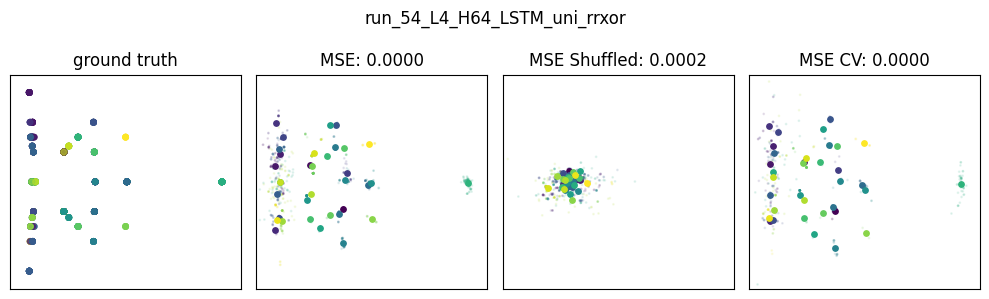

In [162]:
from epsilon_transformers.analysis.activation_analysis import plot_belief_predictions2
# Now plot with flattened arrays
fig, ax = plt.subplots(1, 4, figsize=(10, 3))

plot_belief_predictions(
    belief_predictions=nn_unnormalized_beliefs,
    transformer_input_beliefs=nn_unnormalized_beliefs,
    transformer_input_belief_indices=nn_belief_indices,
    ax=ax[0],
    type=sweep_type,
    title=f'ground truth',
    mode='true',
    include_colorbar=False,
)
plot_belief_predictions(
    belief_predictions=belief_predictions,
    transformer_input_beliefs=nn_unnormalized_beliefs,
    transformer_input_belief_indices=nn_belief_indices,
    ax=ax[1],
    type=sweep_type,
    title=f'MSE: {mse:.4f}',
    mode='predicted',
    include_colorbar=False,
)

plot_belief_predictions(
    belief_predictions=belief_predictions_shuffled,
    transformer_input_beliefs=nn_unnormalized_beliefs,
    transformer_input_belief_indices=nn_belief_indices,
    ax=ax[2],
    type=sweep_type,
    title=f'MSE Shuffled: {mse_shuffled:.4f}',
    mode='predicted',
    include_colorbar=False,
)

plot_belief_predictions(
    belief_predictions=belief_predictions_cv,
    transformer_input_beliefs=nn_unnormalized_beliefs,
    transformer_input_belief_indices=nn_belief_indices,
    ax=ax[3],
    type=sweep_type,
    title=f'MSE CV: {mse_cv:.4f}',
    include_colorbar=False,
    cv_test_inds=test_inds,
    mode='predicted',
)

# make sure all subplots have the same x and y lims
for i in range(4):
    ax[i].set_xlim(ax[0].get_xlim())
    ax[i].set_ylim(ax[0].get_ylim())

# no legend
for i in range(4):
    ax[i].legend().set_visible(False)

# add run_id as global title
fig.suptitle(run_id)
plt.tight_layout()
plt.show()